In [54]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format


df = pd.read_csv("data/df_indi_works_occupations.csv", index_col=0)
print(df.occupation.value_counts())

regions = pd.read_csv(
    "data/ENS - Cultural Index - Countries Databases - region_level.csv"
)
regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = set(regions["region_name"])
df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)

# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]


df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

occupation
Written work    136413
Work of art     124276
Science          73618
Music            50774
Sculpture        33732
Architecture     27600
Theater          15255
Name: count, dtype: int64


In [75]:
df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})


In [56]:
# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

In [57]:
#MODEL 3
equation = 'y ~ bs(decade, knots=iknots, intercept=True) + occupation +(1|region_name)'
# SECOND MODEL
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    equation, 
    sample, 
    family='bernoulli', 
    priors=priors)


base_model_fitted = base_model.fit(
    draws=1000,
    chains=4,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)  # important to run faster and sample more efficiently


Modeling the probability that y==1
Compiling...
Compilation time = 0:00:02.097651
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:28:10.142524
Transforming variables...
Transformation time = 0:00:00.132126
Computing Log Likelihood...
Log Likelihood time = 0:00:16.304422


In [64]:
#region = 'France'
#occupation = 'Architecture'
new_data = {}

#data = df_m[df_m["region_name"] == region]
data = df_m.copy()
new_data["decade"] = data["decade"].values
new_data["occupation"] = data["occupation"].values
new_data["region_name"] =  data["region_name"].values

new_data = pd.DataFrame(new_data)

base_model.predict(base_model_fitted, data=new_data)
posterior_stacked = az.extract(base_model_fitted)
#p = posterior_stacked['y_mean'].values

y_hat = posterior_stacked["y_mean"].values
y_mean = y_hat.mean(axis=1)
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

In [65]:
# Création du dataset

data['y_mean'] = y_mean
data['y_min'] = hdi_data[0]
data['y_max'] = hdi_data[1]

In [66]:
def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    if y ==0:
        return 1
    else:
        return 0

def compute_f2(y):
    if y == 1:
        return 1
    else:
        return 0

data['f0'] = data['y_mean'].apply(lambda x : compute_f0(x))
data['max_f0'] = data['y_min'].apply(lambda x : compute_f0(x))
data['min_f0'] = data['y_max'].apply(lambda x : compute_f0(x))

data['f1'] = data['y'].apply(compute_f1)
data['f2'] = data['y'].apply(compute_f2)

data.to_csv('results/occupation/raw_results.csv')

### Plot Summary table

In [77]:
# Get results for every region
data_group = data.groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum', 'individual_wikidata_id':'count'}).reset_index()
data_group = data_group.rename(columns={'individual_wikidata_id':'N'})

# Get the full number of unseen individuals
data_group['N_unseen'] = data_group['f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_min'] = data_group['min_f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_max'] = data_group['max_f0'] +  data_group['f1'] +  data_group['f2']

# Merge with the works
df_all_works = df.groupby(['region_name'])['count_works'].sum().reset_index()
data_group = pd.merge(df_all_works, data_group, on = 'region_name')
data_group = data_group.rename(columns={'count_works':'count_works_all'})
data_group = pd.merge(df_count_work_model, data_group, on = 'region_name')


# Compute metrics
data_group['completeness'] = data_group['N']/ data_group['N_unseen']
data_group['coverage'] = 1 - data_group['f1']/ data_group['count_works_all']

# Reorder and format the results
data_group = data_group.set_index('region_name')
data_group = data_group[['N', 'f1', 'f2', 'f0', 'N_unseen', 'completeness','coverage', 'count_works_all', 'count_works_f1_f2','min_f0', 'max_f0', 'N_unseen_min', 'N_unseen_max']]
data_group = data_group.T
data_group


region_name,Arabic world,Central Europe,Chinese world,East Slavic,France,German world,Greek World,Indian world,Italy,Japan,Korea,Latin World,Low countries,Nordic countries,Persian world,Portugal,Spain,United Kingdom
N,1101.00,7678.00,1579.00,3426.00,17510.00,27771.00,1158.00,395.00,14573.00,867.00,191.00,314.00,7272.00,4931.00,485.00,701.00,4750.00,9955.00
f1,1025.00,7494.00,1441.00,3306.00,16383.00,26831.00,1093.00,361.00,13953.00,802.00,180.00,271.00,6720.00,4702.00,455.00,677.00,4516.00,9257.00
f2,76.00,184.00,138.00,120.00,1127.00,940.00,65.00,34.00,620.00,65.00,11.00,43.00,552.00,229.00,30.00,24.00,234.00,698.00
f0,9561.90,268560.64,10765.23,72415.21,219257.45,752659.70,13380.83,3147.91,330875.23,6830.55,1946.09,1056.31,76886.14,90984.71,4804.79,15555.55,93207.78,113462.22
N_unseen,10662.90,276238.64,12344.23,75841.21,236767.45,780430.70,14538.83,3542.91,345448.23,7697.55,2137.09,1370.31,84158.14,95915.71,5289.79,16256.55,97957.78,123417.22
completeness,0.10,0.03,0.13,0.05,0.07,0.04,0.08,0.11,0.04,0.11,0.09,0.23,0.09,0.05,0.09,0.04,0.05,0.08
coverage,0.96,0.60,0.98,0.86,0.88,0.67,0.84,0.68,0.79,0.88,-0.50,0.88,0.93,0.82,0.87,0.79,0.75,0.91
count_works_all,26617.00,18655.00,77626.00,22826.00,139020.00,80761.00,6789.00,1144.00,67871.00,6694.00,120.00,2286.00,91737.00,25864.00,3515.00,3273.00,18042.00,105009.00
count_works_f1_f2,1177.00,7862.00,1717.00,3546.00,18637.00,28711.00,1223.00,429.00,15193.00,932.00,202.00,357.00,7824.00,5160.00,515.00,725.00,4984.00,10653.00
min_f0,7990.71,236666.13,9375.77,63247.17,198853.56,682212.64,10441.00,2501.45,297458.98,5723.23,1458.03,794.74,69340.77,80804.79,3855.26,12431.07,82157.44,102574.28


## Plot model results for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

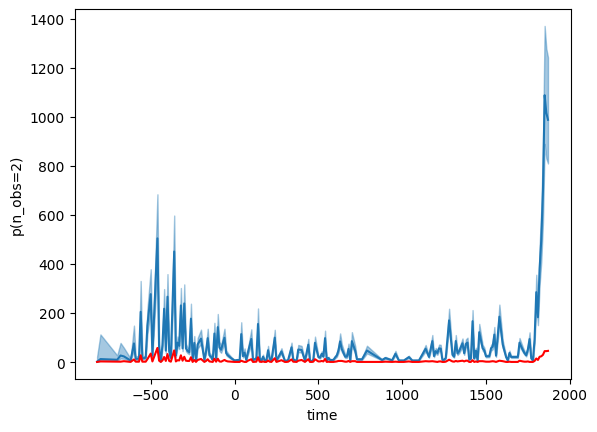

In [73]:
df_filtered = data[data['region_name'] == 'Greek World']

df_filtered = df_filtered.groupby('decade').agg({'f0':'sum', 'f1':'sum', 'f2':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()
df_filtered['N'] = df_filtered['f1'] + df_filtered['f2'] 
df_filtered['N_unseen'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['f0']
df_filtered['N_unseen_min'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['min_f0']
df_filtered['N_unseen_max'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['max_f0']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(df_filtered["decade"], df_filtered['N_unseen'], color='C0')
ax.plot(df_filtered["decade"], df_filtered['N'], color='red')


# Plot credibility bands
ax.fill_between(df_filtered["decade"], df_filtered['N_unseen_min'],  df_filtered['N_unseen_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")



### Plot P(Y=2) for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

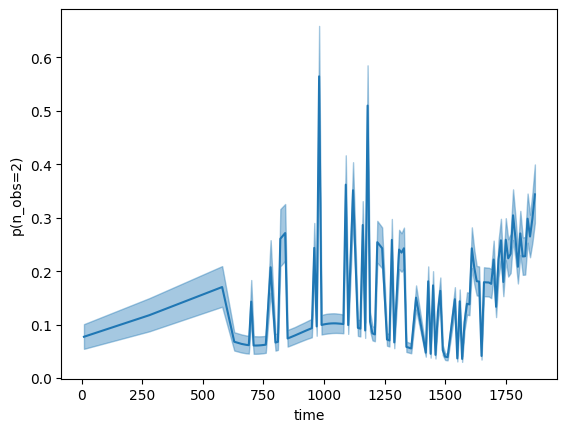

In [71]:
data_f2 = data[['region_name', 'decade', 'y_mean', 'y_min', 'y_max','occupation']].copy()
data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Japan']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(data_f2_filtered["decade"], data_f2_filtered['y_mean'], color='C0')

# Plot credibility bands
ax.fill_between(data_f2_filtered["decade"], data_f2_filtered['y_min'],  data_f2_filtered['y_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
